## Step 0: Load datas & Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Load tensorboard
%cd /content/drive/MyDrive/Colab Notebooks
%load_ext tensorboard
from tensorflow import keras
import os
pwd = os.getcwd()
print(pwd)

/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks


In [3]:
#Load the libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from datetime import datetime

In [4]:
##Read the labels 
import pandas as pd
labels = pd.read_csv('./Data/train/train.csv')
labels = labels.loc[:,['filename','diabetic retinopathy', 'glaucoma','normal']]


## diabetic retinopathy = 1, glaucoma = 2, normal = 0
y = np.empty((len(labels),1))
y[:] = np.NaN
for i in range(len(labels)):
    if labels.loc[i,'normal'] == 1:
        y[i] = 0
    if labels.loc[i,'diabetic retinopathy'] == 1:
        y[i] = 1
    if labels.loc[i,'glaucoma'] == 1:
        y[i] = 2
y = y.reshape(len(labels))
y = y.tolist()
labels['y']=y

# ## Take out images that does not have labels
labels = labels[~labels.y.isna()]

image_list = labels['filename'].tolist()
print('number of images: ',len(image_list))
        


number of images:  1858


In [5]:
# Checking the amount of images in each class. Augment the less images. 
## diabetic retinopathy = 1, glaucoma = 2, normal = 0
print('diabetic retinopathy = 1, glaucoma = 2, normal = 0')
print(labels['y'].value_counts())

diabetic retinopathy = 1, glaucoma = 2, normal = 0
1.0    736
2.0    597
0.0    525
Name: y, dtype: int64


Maximum pixel:  240.0
Shape:  (1, 512, 512, 3)
(512, 512, 3)


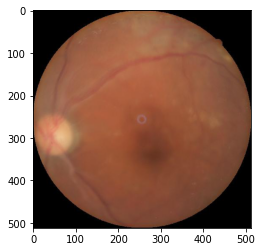

In [ ]:
#Load one image, See what it looks like

img = tf.keras.preprocessing.image.load_img('./Data/train/train/0fb67d22066c.jpg')
plt.imshow(img)
input_arr = keras.preprocessing.image.img_to_array(img)
input_arr = np.array([input_arr])  # Convert single image to a batch.
print('Maximum pixel: ',np.max(input_arr))
print('Shape: ',input_arr.shape)
input_arr /=255 # Normalization
test = input_arr.reshape([input_arr.shape[1],input_arr.shape[2],input_arr.shape[3]])
print(test.shape)


In [5]:
# Load all the images in the image_list
train_img_folder = './Data/train/train'
train_data_array=[]
for img_dir in os.listdir(train_img_folder):
    if img_dir in image_list:
        image_path = os.path.join(train_img_folder, img_dir)
        img = tf.keras.preprocessing.image.load_img(image_path)
        input_arr = keras.preprocessing.image.img_to_array(img)
        input_arr = np.array([input_arr])  # Convert single image to a batch.
        input_arr /=255 # Normalization
        input_arr = input_arr.reshape([input_arr.shape[1],input_arr.shape[2],input_arr.shape[3]])
        train_data_array.append(input_arr)


In [6]:
print(np.shape(train_data_array))

(1858, 512, 512, 3)


In [6]:
# Adjust train data labels to make take out nan values
train_data_label = labels['y'].tolist()
print(np.shape(train_data_label))


(1858,)


## Task 1
```
a. Perform 70/30 data split and report performance scores on the test data set.
b. Data Augmentation
c. Show Training-validation curves.
```

In [26]:
## Train split data
X_train, X_test, y_train, y_test = train_test_split(train_data_array, train_data_label, test_size=0.30, random_state=42)

In [ ]:
# Count the number of different images in the training set
from collections import Counter
Counter(y_train)


Counter({0.0: 368, 1.0: 497, 2.0: 435})

In [ ]:
print(np.shape(X_train),np.shape(y_train))

(1300, 512, 512, 3) (1300,)


In [27]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [28]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [ ]:
num_classes = 3

# Define an AlexNet

In [29]:
# AlexNet
class AlexNet(Sequential):
   def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                    padding='valid', activation= 'relu',
                    input_shape= input_shape, kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))
    
    
    self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None)) 
    

    self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    
    self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    
    self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization())
    
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))
    

    self.add(Flatten())
    self.add(Dense(4096, activation='relu'))
    self.add(Dense(4096, activation='relu', name = 'feature'))
    self.add(Dense(num_classes, activation= 'softmax'))

    self.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [30]:
model = AlexNet((np.shape(X_train)[1],np.shape(X_train)[2], 3), 3)
model.summary()

Model: "alex_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 96)      34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 96)      384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 384)       885

# Data Augmentation
Rotation of 90 degrees, horizontal flip, vertical flip, and zoom range of 0.1 are selected to create data that could be generalized to imperfect images. 

In [31]:
img_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True, vertical_flip = True, zoom_range=0.1 )
img_generator.fit(X_train)
BATCH_SIZE = 100 ## Lowering batch size from size of X_train to 100 because it was killing my RAM
train_generated = img_generator.flow(X_train, y_train, batch_size=BATCH_SIZE)
test_generated = img_generator.flow(X_test, y_test, batch_size=BATCH_SIZE)

In [32]:
#Method 1: Randomized batches
EPOCHS = 50
reg_history_loss = []
reg_history_vloss = []
reg_history_accuracy = []
reg_history_val_accuracy = []
# Start training
for e in range(EPOCHS):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in train_generated:
        reg_hist = (model.fit(x_batch, y_batch,validation_split=0.2, verbose=1))
        batches += 1
        reg_history_loss.append(reg_hist.history['loss'])
        reg_history_vloss.append(reg_hist.history['val_loss'])
        reg_history_accuracy.append(reg_hist.history['accuracy'])
        reg_history_val_accuracy.append(reg_hist.history['val_accuracy'])
        if batches >= 1:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break  

Epoch 0
3/3 [==============================] - 4s 603ms/step - loss: 8864.0016 - accuracy: 0.3695 - val_loss: 247282688.0000 - val_accuracy: 0.2500
Epoch 1
3/3 [==============================] - 0s 151ms/step - loss: 19038.0117 - accuracy: 0.3625 - val_loss: 111579152.0000 - val_accuracy: 0.2000
Epoch 2
3/3 [==============================] - 0s 147ms/step - loss: 982.2586 - accuracy: 0.4125 - val_loss: 17021870.0000 - val_accuracy: 0.5000
Epoch 3
3/3 [==============================] - 0s 144ms/step - loss: 1115.8761 - accuracy: 0.3500 - val_loss: 18985840.0000 - val_accuracy: 0.4000
Epoch 4
3/3 [==============================] - 0s 150ms/step - loss: 628.8856 - accuracy: 0.3750 - val_loss: 12964853.0000 - val_accuracy: 0.3000
Epoch 5
3/3 [==============================] - 0s 146ms/step - loss: 343.3661 - accuracy: 0.3875 - val_loss: 2495035.2500 - val_accuracy: 0.4500
Epoch 6
3/3 [==============================] - 0s 147ms/step - loss: 391.6498 - accuracy: 0.3125 - val_loss: 3320266.25

In [18]:
#Print the loss and accuracies
#print_loss_history(reg_history)
t_loss = np.squeeze(np.array(reg_history_loss))
v_loss = np.squeeze(np.array(reg_history_vloss))
t_acc  = np.squeeze(np.array(reg_history_accuracy))
v_acc  = np.squeeze(np.array(reg_history_val_accuracy))

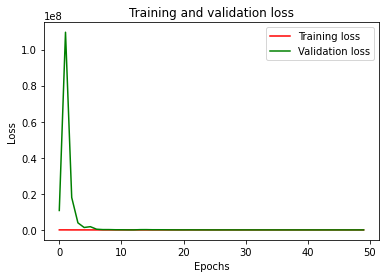

In [19]:
epochs = range(len(t_loss))
plt.plot(epochs, t_loss, color='red', label='Training loss')
plt.plot(epochs, v_loss, color='green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

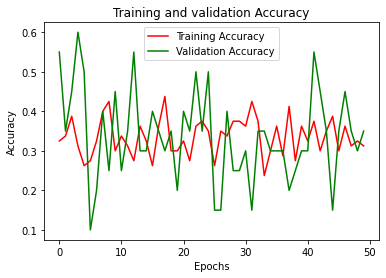

In [20]:
epochs=range(len(t_acc))
plt.plot(epochs, t_acc, color='red', label='Training Accuracy')
plt.plot(epochs, v_acc, color='green', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
# Test Accuracy
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,precision_score,recall_score
prediction_values = np.argmax(model.predict(X_test), axis=-1)
print(f'Accuracy = {accuracy_score(y_test[:, 1], prediction_values)}')
print(f'F1 = {f1_score(y_test[:, 1], prediction_values,average = None)}')
print(f'Precision = {precision_score(y_test[:, 1], prediction_values,average=None)}')
print(f'Recall = {recall_score(y_test[:, 1], prediction_values,average = None)}')
# Display the confusion matrix
print('Confusion matrix =')
print(confusion_matrix(y_test[:, 1], prediction_values))

Accuracy = 0.34050179211469533
F1 = [0.2735426  0.45825933 0.        ]
Precision = [0.48031496 0.39814815 0.        ]
Recall = [0.19122257 0.53974895 0.        ]
Confusion matrix =
[[ 61 195  63]
 [ 66 129  44]
 [  0   0   0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Task 2: Show activation


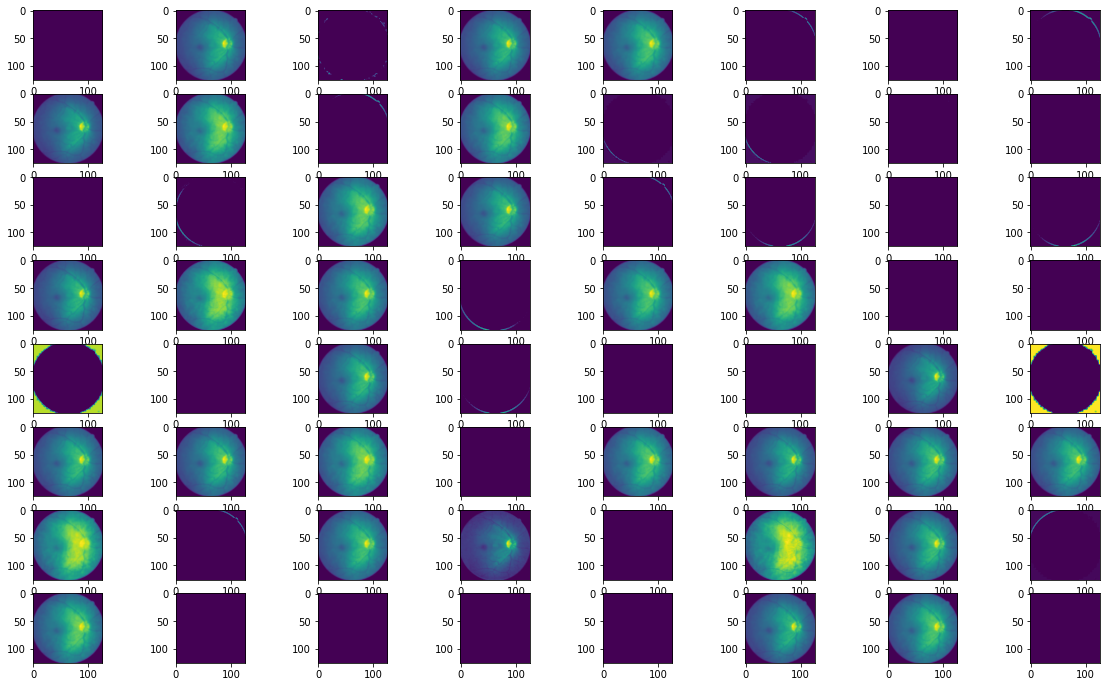

In [ ]:
from keras.models import Model
layer_outputs = [layer.output for layer in model_aug.layers]
activation_model = Model(inputs=model_aug.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[10].reshape(1,512,512,3))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index])
            activation_index += 1

display_activation(activations, 8, 8, 0) #For layer 0


## Task 3: Using the unlabelled data set in the 'test' folder augment the training data (semi-supervised learning) and report the variation in classification performance on test data set.

```
a. Train a model using the 'train' split.
b. Pass the unlabelled images through the trained model and retrieve the dense layer feature prior to classification layer. Using this dense layer as representative of the image, apply label propagation to retrieve labels correspndng to the unbalelled data.
c. Next, concatenate the train data with the unlabelled data (that has now been self labelled) and retrain the network.
d. Report classification performance on test data
Use the unlabelled test data  to improve classification performance by using a semi-supervised label-propagation/self-labelling approach. 
```

### Load 'test' data

In [36]:
# import test images
test_img_folder = './Data/test/test'
test_data_array=[]
for img_dir in os.listdir(test_img_folder):
  image_path = os.path.join(test_img_folder, img_dir)
  img = tf.keras.preprocessing.image.load_img(image_path)
  input_arr = keras.preprocessing.image.img_to_array(img)
  input_arr = np.array([input_arr])  # Convert single image to a batch.
  input_arr /=255 # Normalization
  input_arr = input_arr.reshape([input_arr.shape[1],input_arr.shape[2],input_arr.shape[3]])
  test_data_array.append(input_arr)


In [37]:
#Only adding the 1st 100 pics from train dataset becasue the whole dataset is crushing my computer
test_data_array =np.concatenate((np.array(train_data_array[1:100]), np.array(test_data_array)), axis=0) 
test_data_array = np.array(test_data_array)

In [34]:
np.shape(test_data_array)

(350, 512, 512, 3)

### Use the above AlexNet model to train the combine data from 'train' and 'test'. 
```
Pass the unlabelled images through the trained model and retrieve the dense layer feature prior to classification layer. Using this dense layer as representative of the image, apply label propagation to retrieve labels correspndng to the unbalelled data.

Concatenate the train data with the unlabelled data (that has now been self labelled) and retrain the network.
```


In [38]:
# Get features from the model
feature_network = Model(model.input, model.get_layer('feature').output)
feature_train = feature_network.predict(X_train)
feature_test = feature_network.predict(test_data_array)

In [ ]:
print(feature_train.shape)
print(feature_test.shape)

In [39]:
# Switch one-hot-code into actual numbers
y_label_train = np.argmax(y_train, axis=-1)

In [40]:
# Label Propagation
import numpy as np
from sklearn import datasets
from sklearn.semi_supervised import LabelPropagation
label_prop_model = LabelPropagation()
label_prop_model.fit(feature_train, y_label_train)

LabelPropagation(gamma=20, kernel='rbf', max_iter=1000, n_jobs=None,
                 n_neighbors=7, tol=0.001)

In [41]:
y_testdata_labels = label_prop_model.predict(feature_test)
y_testdata_labels = to_categorical(y_testdata_labels)
y_total = np.concatenate((to_categorical(train_data_label[1:100]),y_testdata_labels),axis = 0)
print(y_total.shape)

(548, 3)


/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:201: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


In [42]:
# Combine data
model_new = AlexNet((np.shape(X_train)[1],np.shape(X_train)[2], 3), 3)
model_new.fit(test_data_array ,y_total,batch_size=100,validation_split=0.2,verbose=1, epochs=50)

Epoch 1/50
4/4 [==============================] - 6s 1s/step - loss: 10302.2331 - accuracy: 0.5077 - val_loss: 765186.0625 - val_accuracy: 0.2111
Epoch 2/50
4/4 [==============================] - 1s 353ms/step - loss: 387.0439 - accuracy: 0.6249 - val_loss: 177709.2500 - val_accuracy: 0.9889
Epoch 3/50
4/4 [==============================] - 1s 364ms/step - loss: 147.3007 - accuracy: 0.6780 - val_loss: 51063.6484 - val_accuracy: 0.9889
Epoch 4/50
4/4 [==============================] - 1s 362ms/step - loss: 154.7741 - accuracy: 0.7940 - val_loss: 2620005.0000 - val_accuracy: 0.0111
Epoch 5/50
4/4 [==============================] - 1s 363ms/step - loss: 60.3147 - accuracy: 0.7503 - val_loss: 4014770.7500 - val_accuracy: 0.0111
Epoch 6/50
4/4 [==============================] - 1s 363ms/step - loss: 36.4632 - accuracy: 0.7881 - val_loss: 2580942.2500 - val_accuracy: 0.0111
Epoch 7/50
4/4 [==============================] - 1s 350ms/step - loss: 24.5038 - accuracy: 0.6616 - val_loss: 1134710.

### Classification performance

In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,precision_score,recall_score
prediction_values = np.argmax(model_new.predict(X_test), axis=-1)
print(f'Accuracy = {accuracy_score(y_test[:, 1], prediction_values)}')
print(f'F1 = {f1_score(y_test[:, 1], prediction_values,average = None)}')
print(f'Precision = {precision_score(y_test[:, 1], prediction_values,average=None)}')
print(f'Recall = {recall_score(y_test[:, 1], prediction_values,average = None)}')
# Display the confusion matrix
print('Confusion matrix =')
print(confusion_matrix(y_test[:, 1], prediction_values))

Accuracy = 0.3906810035842294
F1 = [0.13483146 0.57142857 0.        ]
Precision = [0.64864865 0.44090909 0.        ]
Recall = [0.07523511 0.81171548 0.        ]
Confusion matrix =
[[ 24 246  49]
 [ 13 194  32]
 [  0   0   0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Draft: Other models I have tried

# Try VGG net

In [23]:
# VGGNet
class VGGNet(Sequential):
   def __init__(self, input_shape, num_classes=3):
    super().__init__()

    self.add(Conv2D(64, kernel_size=(3,3), strides= 4,
                    padding='valid', activation= 'relu',
                    input_shape= input_shape, kernel_initializer= 'he_normal'))
    self.add(BatchNormalization()) 
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))
    
    
    self.add(Conv2D(128, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization()) 
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None)) 
    

    self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))  
    self.add(BatchNormalization()) 
    # self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
    #                 padding= 'same', activation= 'relu',
    #                 kernel_initializer= 'he_normal'))
    # self.add(BatchNormalization()) 
    # self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
    #                 padding= 'same', activation= 'relu',
    #                 kernel_initializer= 'he_normal'))
    # self.add(BatchNormalization()) 
    # self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
    #                 padding= 'same', activation= 'relu',
    #                 kernel_initializer= 'he_normal'))
    # self.add(BatchNormalization()) 
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None)) 

    self.add(Conv2D(512, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization()) 
    # self.add(Conv2D(512, kernel_size=(3,3), strides= 1,
    #                 padding= 'same', activation= 'relu',
    #                 kernel_initializer= 'he_normal'))
    # self.add(BatchNormalization()) 
    # self.add(Conv2D(512, kernel_size=(3,3), strides= 1,
    #                 padding= 'same', activation= 'relu',
    #                 kernel_initializer= 'he_normal'))
    # self.add(BatchNormalization()) 
    # self.add(Conv2D(512, kernel_size=(3,3), strides= 1,
    #                 padding= 'same', activation= 'relu',
    #                 kernel_initializer= 'he_normal'))
    # self.add(BatchNormalization()) 
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))
    
    self.add(Conv2D(512, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(BatchNormalization()) 
    # self.add(Conv2D(512, kernel_size=(3,3), strides= 1,
    #                 padding= 'same', activation= 'relu',
    #                 kernel_initializer= 'he_normal'))
    # self.add(BatchNormalization()) 
    # self.add(Conv2D(512, kernel_size=(3,3), strides= 1,
    #                 padding= 'same', activation= 'relu',
    #                 kernel_initializer= 'he_normal'))
    # self.add(BatchNormalization()) 
    # self.add(Conv2D(512, kernel_size=(3,3), strides= 1,
    #                 padding= 'same', activation= 'relu',
    #                 kernel_initializer= 'he_normal'))
    # self.add(BatchNormalization()) 
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))
    
    

    self.add(Flatten())
    self.add(Dense(4096, activation='relu'))
    self.add(Dropout(0.5))
    self.add(Dense(4096, activation='relu', name = 'feature'))
    self.add(Dense(num_classes, activation= 'softmax'))

    self.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [93]:
model = VGGNet((np.shape(X_train)[1],np.shape(X_train)[2], 3), 3)
model.summary()

Model: "vgg_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_451 (Conv2D)          (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_160 (Bat (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_452 (Conv2D)          (None, 63, 63, 128)       73856     
_________________________________________________________________
batch_normalization_161 (Bat (None, 63, 63, 128)       512       
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_453 (Conv2D)          (None, 31, 31, 256)       2951

# Inception

In [17]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers.merge import concatenate
from keras.utils import plot_model
 
def inception_1(layer_in,k1):
  # 1st
  conv1_1 = Conv2D(k1, (1,1), strides = (2,2), padding='same', activation='relu')(layer_in)
  conv1_2 = Conv2D(k1, (3,3), padding='same', activation='relu')(conv1_1)
  conv1 = Conv2D(k1, (5,5), padding='same', activation='relu')(conv1_2)
  conv1 = BatchNormalization()(conv1)
  #2nd
  conv2_1 = Conv2D(k1, (1,1), strides = (2,2),padding='same', activation='relu')(layer_in)
  conv2 = Conv2D(k1, (3,3), padding='same', activation='relu')(conv2_1)
  conv2 = BatchNormalization()(conv2)
  #3rd
  pool = MaxPooling2D((1,1), padding='same')(layer_in)
  conv3 = Conv2D(k1, (1,1),  strides = (2,2), padding = 'same', activation = 'relu')(pool)
  conv3 = BatchNormalization()(conv3)
  #4th
  conv4 = Conv2D(k1, (1,1),strides = (2,2), padding='same', activation='relu')(layer_in)
  conv4 = BatchNormalization()(conv4)
  # concatenate filters, assumes filters/channels last
  layer_out = concatenate([conv1, conv2, conv3, conv4], axis=-1)
  return layer_out
  return conv1

def inception_2(layer_in,k2):
  # 1st
  conv1_1 = Conv2D(k2, (1,1),strides = (2,2),  padding='same', activation='relu')(layer_in)
  conv1_2 = Conv2D(k2, (1,7), padding='same', activation='relu')(conv1_1)
  conv1_3 = Conv2D(k2, (7,1), padding='same', activation='relu')(conv1_2)
  conv1_4 = Conv2D(k2, (1,7), padding='same', activation='relu')(conv1_3)
  conv1_5 = Conv2D(k2, (7,1), padding='same', activation='relu')(conv1_4)
  conv1 = BatchNormalization()(conv1_5)

  # #2nd
  conv2_1 = Conv2D(k2, (1,1),strides = (2,2),  padding='same', activation='relu')(layer_in)
  conv2_2 = Conv2D(k2, (1,7), padding='same', activation='relu')(conv2_1)
  conv2_3 = Conv2D(k2, (7,1), padding='same', activation='relu')(conv2_2)
  conv2 = BatchNormalization()(conv2_3)

  #3rd
  pool = MaxPooling2D((1,1), padding='same')(layer_in)
  conv3_1 = Conv2D(k2, (1,1), strides = (2,2), padding = 'same', activation = 'relu')(pool)
  conv3 = BatchNormalization()(conv3_1)
  #4th
  conv4_1 = Conv2D(k2, (1,1), strides = (2,2), padding='same', activation='relu')(layer_in)
  conv4 = BatchNormalization()(conv4_1)
  # concatenate filters, assumes filters/channels last
  layer_out = concatenate([conv1, conv2, conv3, conv4], axis=-1)
  return layer_out 

def inception_3(layer_in,k3):
  # 1st
  conv1_1 = Conv2D(k3, (1,1),strides = (2,2),  padding='same', activation='relu')(layer_in)
  conv1_2 = Conv2D(k3, (3,3), padding='same', activation='relu')(conv1_1)
  conv1_3 = Conv2D(k3, (1,3), padding='same', activation='relu')(conv1_2)
  conv1 = BatchNormalization()(conv1_3)
  # 2nd
  conv2_1 = Conv2D(k3, (3,1), padding='same', activation='relu')(conv1_2)
  conv2 = BatchNormalization()(conv2_1)


# 3rd
  conv3_1 = Conv2D(k3, (1,1),strides = (2,2),  padding='same', activation='relu')(layer_in)
  conv3_2 = Conv2D(k3, (1,3), padding='same', activation='relu')(conv3_1)
  conv3 = BatchNormalization()(conv3_2)
# 4th
  conv4_1 = Conv2D(k3, (3,1), padding='same', activation='relu')(conv3_1)
  conv4 = BatchNormalization()(conv4_1)

  #5th
  pool = MaxPooling2D((1,1), padding='same')(layer_in)
  conv5_1 = Conv2D(k3, (1,1), strides = (2,2), padding = 'same', activation = 'relu')(pool)
  conv5 = BatchNormalization()(conv5_1)
  #6th
  conv6_1 = Conv2D(k3, (1,1), strides = (2,2), padding='same', activation='relu')(layer_in)
  conv6 = BatchNormalization()(conv6_1)
  # concatenate filters, assumes filters/channels last
  layer_out = concatenate([conv1, conv2, conv3, conv4,conv5,conv6], axis=-1)
  return layer_out 
 
# define model input
visible = Input(shape=(512, 512, 3))
conv1 = Conv2D(32, (3,3), strides= (2,2), padding='valid', activation='relu')(visible)
conv1 = BatchNormalization()(conv1)
conv2 = Conv2D(32, (3,3), padding='valid', activation='relu')(conv1)
conv2 = BatchNormalization()(conv2)
conv3 = Conv2D(64, (3,3), padding='same', activation='relu')(conv2)
conv3 = BatchNormalization()(conv3)
pool = MaxPooling2D((3,3), strides=(2,2), padding='same')(conv3)
conv4 = Conv2D(80, (3,3), padding='valid', activation='relu')(pool)
conv4 = BatchNormalization()(conv4)
conv5 = Conv2D(192, (3,3),strides=(2,2), padding='valid', activation='relu')(conv4)
conv5 = BatchNormalization()(conv5)
conv6 = Conv2D(288, (3,3), padding='valid', activation='relu')(conv5)
conv6 = BatchNormalization()(conv6)
# add inception module
layer = inception_1(conv6,35)
layer_2 = inception_2(layer,17)
layer_3 = inception_3(layer_2,8)
pool_2 = MaxPooling2D((8,8),padding='same')(layer_3)
flat = Flatten()(layer_3)

dense1 = Dense(2048, activation='relu', name = 'feature')(flat)
result = Dense(3, activation='softmax')(dense1)
# create model
model = Model(inputs=visible, outputs=result)
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
# summarize model
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 255, 255, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 255, 255, 32) 128         conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 253, 253, 32) 9248        batch_normalization_20[0][0]     
____________________________________________________________________________________________